In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import optuna as ot

print(np.__version__)

1.26.4


In [29]:
data = pd.read_csv('aggregated_data.csv')

# INFLATION ADJUSTMENT
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['CORN_FUTURES_TYPICAL_PRICE'] = data['CORN_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] = data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['US_MXN_RATES'] = data['US_MXN_RATES'] * (base_cpi/data['CPI_US'])
data['DIESEL_RETAIL_PRICE'] = data['DIESEL_RETAIL_PRICE'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

# ['avg_price_steers_ML1', 'avg_price_steers_ML1_2', 'avg_price_heifers_ML1', 'avg_price_heifers_ML1_2', 'CPI_US', 'NATIONAL_AUCTION_SALES','NATIONAL_TOTAL_SALES', 'TEXAS_AUCTION_SALES']
data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop(['avg_price_steers_ML1', 'avg_price_steers_ML1_2', 'avg_price_heifers_ML1', 'avg_price_heifers_ML1_2', 'NATIONAL_AUCTION_SALES','NATIONAL_TOTAL_SALES', 'TEXAS_AUCTION_SALES'], axis=1)
# print(data.head())


In [30]:
def print_metrics(X_test, y_test, y_pred): # Helper function to print model metrics
    r2 = r2_score(y_test, y_pred) # R²
    # print(f'R² Score: {r2}')

    # n = X_test.shape[0]
    # k = X_test.shape[1]
    # adj_r2 = 1-((1-rf_r2)*(n-1)/(n-k-1)) # Adjusted-R²
    # print(f'Adjusted-R² Score: {adj_r2}')

    prcorr = np.corrcoef(y_test, y_pred)[0,1] # Pearson Correlation Coefficient 
    # print("Pearson correlation:", prcorr)

    srcorr, p_value = spearmanr(y_test, y_pred) # Spearman’s Rank Correlation
    # print("Spearman correlation:", srcorr)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE
    # print(f'Root Mean Squared Error (RMSE): {rmse}')

    mae = mean_absolute_error(y_test, y_pred) # MAE
    # print(f'Mean Absolute Error (MAE): {mae}')

    return (r2, prcorr, srcorr, rmse, mae)

def create_lag_features(df, target_col='diff_1', num_lags=1):
    df_lagged = df.copy()
    for lag in range(1,num_lags+1):
        df_lagged[f'{target_col}_lag{lag}'] = df_lagged[target_col].shift(lag)
    return df_lagged

## RANDOM FOREST MODEL

In [31]:
# # CREATE RANDOM FOREST MODEL
X = data.drop(['AVG_PRICE_AUCTION'], axis=1)
y = data['AVG_PRICE_AUCTION']

# # SPLIT DATA INTO 80/20 TRAINING TESTING SETS
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
X_train = train_data.drop('AVG_PRICE_AUCTION', axis=1)
y_train = train_data['AVG_PRICE_AUCTION']
X_test = test_data.drop('AVG_PRICE_AUCTION', axis=1)
y_test = test_data['AVG_PRICE_AUCTION']

# CREATE AND TRAIN RF REGRESSOR
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# MAKE PREDICTIONS ON TEST SET
rf_pred = rf_regressor.predict(X_test)

# EVALUATING MODEL PERFORMANCE
print_metrics(X_test, y_test, rf_pred)

(-3.943770797294584,
 -0.5021780690567789,
 -0.2531698115427593,
 32.846519439939755,
 25.31080373094651)

In [32]:
# PERFORM DIFFERENCING
data['diff_1'] = data['AVG_PRICE_AUCTION'].diff(periods=1).bfill()
# print(data['diff_1'])

# plot_acf(data['diff_1'], ax=plt.gca())
# plot_pacf(data['diff_1'], ax=plt.gca())

# PREDICT LAGGED PRICE
test_lags = [1,2,3,4,5]
results = []
tscv = TimeSeriesSplit(n_splits=5)

for num_lags in test_lags:
    # CREATE LAGGED DATASET
    df_lagged = create_lag_features(data, target_col='diff_1', num_lags=num_lags).bfill()

    X = df_lagged[[f'diff_1_lag{i}' for i in range(1, num_lags+1)]]
    y = df_lagged['diff_1']

    r2 = []
    prcorr = []
    mae = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        rf_pred = model.predict(X_test)
        metrics = print_metrics(X_test, y_test, rf_pred)

        r2.append(metrics[0])
        prcorr.append(metrics[1])
        mae.append(metrics[4])

    avg_r2 = np.mean(r2)
    avg_prcorr = np.mean(prcorr)
    avg_mae = np.mean(mae)
    results.append((num_lags, avg_r2, avg_prcorr, avg_mae))
    print(f"Lags={num_lags}, R2={avg_r2:.3f}, Pearson Correlation={avg_prcorr:.3f}, MAE={avg_mae:.3f}")

best_lag, best_r2, best_prcoeff, best_mae = max(results, key=lambda x: x[1])
print(f"\nBest number of lags: {best_lag} with R2={best_r2:.3f}")

Lags=1, R2=-0.109, Pearson Correlation=0.349, MAE=5.755
Lags=2, R2=0.081, Pearson Correlation=0.401, MAE=5.354
Lags=3, R2=0.098, Pearson Correlation=0.407, MAE=5.343
Lags=4, R2=0.097, Pearson Correlation=0.399, MAE=5.369
Lags=5, R2=0.100, Pearson Correlation=0.394, MAE=5.358

Best number of lags: 5 with R2=0.100


In [33]:
# PREDICT ORIGINAL PRICE
results = []

exog_features = [
    'CORN_FUTURES_TYPICAL_PRICE',
    'FEEDER_CATTLE_FUTURES_TYPICAL_PRICE',
    'US_MXN_RATES',
    'DIESEL_RETAIL_PRICE',
    'CPI_US'
]

for num_lags in test_lags:
    # CREATE LAGGED DATASET
    df_lagged = create_lag_features(data, target_col='diff_1', num_lags=num_lags).bfill()

    lag_cols = [f'diff_1_lag{i}' for i in range(1, num_lags + 1)]
    X_cols = lag_cols + exog_features

    X = df_lagged[X_cols]
    y = df_lagged['AVG_PRICE_AUCTION']

    r2_list = []
    prcorr_list = []
    mae_list = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        rf_pred = model.predict(X_test)
        metrics = print_metrics(X_test, y_test, rf_pred)

        r2.append(metrics[0])
        prcorr.append(metrics[1])
        mae.append(metrics[4])

    avg_r2 = np.mean(r2)
    avg_prcorr = np.mean(prcorr)
    avg_mae = np.mean(mae)
    
    results.append((num_lags, avg_r2, avg_prcorr, avg_mae))
    print(f"Lags={num_lags}, R2={avg_r2:.3f}, Pearson Correlation={avg_prcorr:.3f}, MAE={avg_mae:.3f}")

best_lag, best_r2, best_prcoeff, best_mae = max(results, key=lambda x: x[1])
print(f"\nBest number of lags: {best_lag} with R2={best_r2:.3f}")

Lags=1, R2=-0.502, Pearson Correlation=0.327, MAE=10.236
Lags=2, R2=-0.705, Pearson Correlation=0.304, MAE=11.900
Lags=3, R2=-0.806, Pearson Correlation=0.294, MAE=12.725
Lags=4, R2=-0.879, Pearson Correlation=0.287, MAE=13.254
Lags=5, R2=-0.920, Pearson Correlation=0.287, MAE=13.583

Best number of lags: 1 with R2=-0.502


## XGBOOST MODEL

In [34]:
# CREATE AND TRAIN XGBOOST REGRESSOR
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)

# EVALUATING MODEL PERFORMANCE
print_metrics(X_test, y_test, xgb_pred)

(-6.655155705883412,
 -0.3059929512615395,
 -0.19249074563722893,
 41.3917456811772,
 34.44500115583023)

## LINEAR REGRESSION MODEL

In [35]:
# CREATE AND TRAIN LINEAR REGRESSION MODEL
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lrg_pred = lin_reg.predict(X_test)

# EVALUATING MODEL PERFORMANCE
print_metrics(X_test, y_test, lrg_pred)

(-0.6519886272711553,
 0.6505169062296615,
 0.6226335272342675,
 19.22827192445417,
 15.441535068841416)

## ARIMA MODEL

(0.01, False)


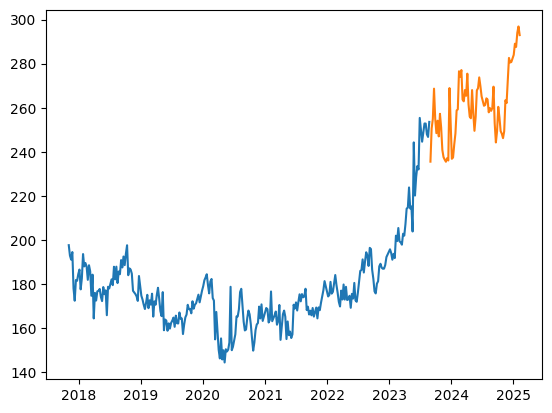

In [36]:
# freq = pd.infer_freq(data.index)
# print('Inferred frequency:', freq)

# FIND WHICH DATA POINTS ARE MISSING
start_date = data.index.min()
end_date = data.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='W-FRI')
missing_dates = full_index.difference(data.index)
# print("Missing Dates:")
# print(missing_dates)

# REINDEX DATA & IMPUTE MISSING VALUES
# duplicates = data.index[data.index.duplicated()]
# print("Duplicate date entries:\n", duplicates)
arima_data = data.reindex(full_index).interpolate(method='linear')
price_series = arima_data['AVG_PRICE_AUCTION']

freq = pd.infer_freq(arima_data.index)
# print('Inferred frequency:', freq)

# PERFORM DIFFERENCING
price_series_diff = price_series.diff().dropna()

# CHECK FOR STATIONARY WITH ADF TEST
# adf_test = adfuller(price_series)
# print(f'ADF Statistic: {adf_test[0]}')
# print(f'p-value: {adf_test[1]}')

adf_test2 = ADFTest(alpha=0.05)
print(adf_test2.should_diff(price_series_diff))

# price_series_diff.plot()

n = len(price_series)
train_size = int(n * 0.8)  # 80%

train = price_series.iloc[:train_size]
test = price_series.iloc[train_size:]

plt.plot(train)
plt.plot(test)

# arima_model = auto_arima(
#     train, start_p=0, d=1, start_q=0,
#     max_p=5, max_d=5, max_q=5, start_P=0,
#     D=1, start_Q=0, max_P=5, max_D=5,
#     max_Q=5, m=52, seasonal=True,
#     error_action='warn', trace=True,
#     suppress_warnings=True, stepwise=True,
#     random_state=20, n_fits=50
# )

# # CREATE AND TRAIN ARIMA MODEL
# model = ARIMA(train, order=(3, 1, 0), seasonal_order=(1, 1, 1, 52))
# model_fit = model.fit()
# # print(model_fit.summary())

# # FORECAST DATA
# forecast_length = len(test)
# test_forecast = model_fit.forecast(steps=forecast_length)
# test_forecast.index = test.index

# print_metrics(arima_data.index, test, test_forecast)

NameError: name 'test_forecast' is not defined

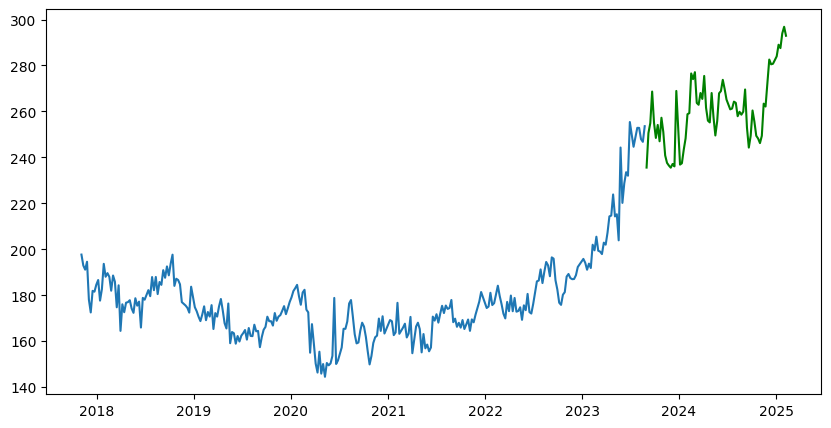

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test_forecast.index, test_forecast, label='Forecast', color='red', linestyle='--')
plt.legend()
plt.show()

## DATA VISUALIZATION

In [ ]:
# VISUALIZATION OF DATA
fig = go.Figure()

# Historical (Training) data trace
fig.add_trace(go.Scatter(
    x=X_train.index, y=y_train,
    mode='lines+markers',
    name='Historical (Train)',
    line=dict(color='blue')
))

# Actual test data trace
fig.add_trace(go.Scatter(
    x=X_test.index, y=y_test,
    mode='lines+markers',
    name='Actual (Test)',
    line=dict(color='black')
))

# Forecast (Predicted) data trace
fig.add_trace(go.Scatter(
    x=X_test.index, y=lrg_pred,
    mode='lines+markers',
    name='Forecast (Predicted)',
    line=dict(color='red')
))

# Update layout with titles and axis labels
fig.update_layout(
    title='Model Fit: Historical Data and Forecast',
    xaxis_title='Date',
    yaxis_title='AVG_PRICE_AUCTION (Inflation Adjusted)',
    template='plotly_white'
)